In [2]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from peakutils import indexes
import cv2

In [3]:
def jasonReader(path):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open(path,'r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [4]:
def wholecellParser(dictres):
    #extract all the slices data
    allSlices = dictres['image']
    #seting columns names
    column_names = ['max_peaks_positions','max_peaks_intensities','min_peaks_positions','min_peaks_intensities','amplitudes','times_to_peaks','tau_s']
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in column_names:
        df_sum.loc[:,i] = allSlices[i][:2]

    return df_sum

In [5]:
def derivate_date(array):
    return np.gradient(array, axis=None, edge_order=1)

def _apply_billateral_filter(image_data, diameter, sigma_color, sigma_space):
    return cv2.bilateralFilter(image_data, diameter, sigma_color, sigma_space)

In [6]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
  12         the length of the window. Must be an odd integer number.
  13     order : int
  14         the order of the polynomial used in the filtering.
  15         Must be less then `window_size` - 1.
  16     deriv: int
  17         the order of the derivative to compute (default = 0 means only smoothing)
  18     Returns
  19     -------
  20     ys : ndarray, shape (N)
  21         the smoothed signal (or it's n-th derivative).
  22     Notes
  23     -----
  24     The Savitzky-Golay is a type of low-pass filter, particularly
  25     suited for smoothing noisy data. The main idea behind this
  26     approach is to make for each point a least-square fit with a
  27     polynomial of high order over a odd-sized window centered at
  28     the point.
  40     References
  41     ----------
  42     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
  43        Data by Simplified Least Squares Procedures. Analytical
  44        Chemistry, 1964, 36 (8), pp 1627-1639.
  45     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
  46        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
  47        Cambridge University Press ISBN-13: 9780521880688
  48     """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [7]:
def slicesParser_gradient(dictres,min_dist_between_max_peak):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(dictres['image']['max_peaks_positions']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    for _slice in range(len(allSlices)):
        slice_intensities = allSlices[_slice]['intensities']
        #calculate gradient
        yhat = derivate_date(np.array(slice_intensities))
#         yhat = savitzky_golay(np.array(slice_intensities), 25, int(len(allSlices[_slice]['intensities'])/min_dist_between_max_peak),1)
        #Maximun gradient
        amp_list = _max_peaks_positions(yhat, min_dist_between_max_peak)
        gradient_list = _intensities_in_positions(yhat, amp_list)[:len(dictres['image']['max_peaks_positions'])]
        if len(gradient_list)==len(dictres['image']['max_peaks_positions']):
            #populating the dataframe
            df_sum.loc[_slice] = gradient_list
        else:
            pass
    return df_sum

In [8]:
def _max_peaks_positions(vector, min_dist_between_max_peaks):
    threshold = 0.2
    possible_max_peaks = indexes(np.array(vector), thres=threshold, min_dist=min_dist_between_max_peaks)
    intensity_avg = sum(vector) / len(vector)
    max_peaks = [max_peak for max_peak in possible_max_peaks if vector[max_peak] > intensity_avg/8]

    if len(max_peaks) == 0: raise ValueError("Peaks not found")

    return max_peaks

def _analyze_matrix_slice(matrix, max_peaks_positions):
    intensities = np.asarray(_mean_columns(matrix), dtype=np.float16)
    max_peaks_intensities = _intensities_in_positions(intensities, max_peaks_positions)

    return ({
        "max_peaks_intensities": max_peaks_intensities,

    })
def _intensities_in_positions(intensities, positions):
    return [intensities[position] for position in positions]

def _mean_columns(slice):
    return np.asarray([float(np.mean(row)) for row in slice])

def _min_peaks_positions(intensities, max_peaks):
    minimums = []
    last_max = 0
    for max_index in max_peaks:
        minimums.append(minimo_bl(intensities[last_max:max_index]) + last_max)
        last_max = max_index

    minimums.append(minimo_bl(intensities[last_max:len(intensities)]) + last_max)

    return minimums

def minimo_bl (vector):
    b = -min((x, -i) for i, x in enumerate(vector))[1]
    return b

In [9]:
def discordance_index(path,min_dist_between_max_peaks):
    DIs = pd.DataFrame()
    for j in range (1,len(slicesParser_gradient(path,min_dist_between_max_peaks).columns)):
        rel_diff = []
        for i in range (1, len (slicesParser_gradient(path,min_dist_between_max_peaks))):
            T1 = list(slicesParser_gradient(path,min_dist_between_max_peaks)['transient'+str(j)])[i]
            T2 = list(slicesParser_gradient(path,min_dist_between_max_peaks)['transient'+str(j+1)])[i]
            rel_diff.append((T1-T2)/max(T1,T2))
        DIs[j] = rel_diff
    return DIs

In [ ]:
path_imagenes = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/'
df_tabulado = pd.read_csv(path_imagenes + 'tabulado_imagenes.csv', index_col= 'Unnamed: 0')

dict_min_dist = {1:200,3:70,4:50,5:40,6:20} 

In [ ]:
df_tabulado[(df_tabulado['experimento']==160712) &  (df_tabulado['foto'].isin(['5b000']))]['frecuencia'].reset_index(drop=True)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/imagenes/37°/'
df = pd.DataFrame()
for foto in os.listdir(path):
    if 'json' in foto:
        print(foto)
        experiment = foto.split('_')[1][:6]
        photo = foto.split('_')[-1].split('.')[0]
        frec = df_tabulado[(df_tabulado['experimento'].isin([experiment])) &  (df_tabulado['foto'].isin([photo]))]['frecuencia'].reset_index(drop=True)[0]
        min_dist_between_max_peaks = dict_min_dist[frec]
        array = jasonReader(path + foto)
        discordance_list = discordance_index(array,min_dist_between_max_peaks).std()
        df[foto[:-4]] = discordance_list

In [98]:
dictres = jasonReader('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/jsons/070119Ctrol6_analysis_result_c6b000.json')
array = dictres['image']['intensities']
dist_between_peaks = 20

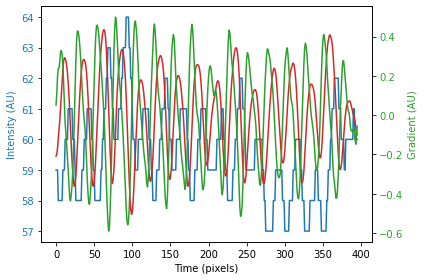

{'max_peaks_intensities': [61.0, 61.0, 63.0, 64.0, 61.0, 62.0, 61.0, 61.0, 61.0, 62.0, 60.0, 59.0, 60.0, 59.0, 62.0, 61.0]}
{'max_peaks_intensities': [0.3296, 0.429, 0.459, 0.4998, 0.4797, 0.4646, 0.411, 0.4626, 0.2517, 0.4336, 0.318, 0.338, 0.3433, 0.3665, 0.411, 0.278]}
[8, 33, 58, 81, 107, 131, 157, 181, 210, 231, 260, 284, 305, 332, 354, 379, 395]
[7, 28, 54, 78, 104, 129, 154, 178, 202, 227, 251, 277, 303, 327, 351, 377]


In [99]:
# deriv = derivate_date(array)
deriv = savitzky_golay(np.array(array), 25, 8 ,1)
deriv = deriv.astype(np.float32, copy=False)
deriv = cv2.bilateralFilter(deriv, 11, 150, 150)
yhat1 = derivate_date(deriv[:,0]*5)
# yhat1 = savitzky_golay(np.array(deriv[:,0]), 25, 8 ,1)

t = range(len(array))
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time (pixels)')
ax1.set_ylabel('Intensity (AU)', color=color)
ax1.plot(t, array, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Gradient (AU)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, deriv, color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
ax2.set_ylabel('Gradient (AU)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, yhat1, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/gradient',dpi=300)
plt.show()
print(_analyze_matrix_slice(array, _max_peaks_positions(array, dist_between_peaks)))
# print(_analyze_matrix_slice(deriv, _max_peaks_positions(deriv, dist_between_peaks)))
print(_analyze_matrix_slice(yhat1, _max_peaks_positions(yhat1, dist_between_peaks)))

print(_min_peaks_positions(array, _max_peaks_positions(array, dist_between_peaks)))
print(_max_peaks_positions(yhat1, dist_between_peaks))

### Precisión y exactitud amplitud

In [199]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
file_tabulado = pd.read_excel(path + 'tab_prueba2.xlsx')
del file_tabulado['Unnamed: 0']

In [200]:
df_manual = pd.read_csv("/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/DI_manual_1hz.csv", sep=",")
df_manual.head(2)

,experimento,foto,pico,Intensidad_max,tiempo_max,Intensidad_min,tiempo_min,Amplitud,TTP,TTP_manual,TTP_deriv
0,200121,C1a000,1,43.19,125,17.89,118,1.414198,7,4.949802,11
1,200121,C1a000,2,42.64,360,16.80,354,1.538095,6,3.900929,14


In [201]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
dif_amp = pd.DataFrame()
dias = df_manual['experimento'].drop_duplicates()
foto = df_manual['foto'].drop_duplicates()
for j in dias:
    for k in foto:
        for i in range(0,len (experiments)):
            if (str(j) in experiments[i]) & (k in experiments[i]):
                try:
                    experiment = jasonReader(path + 'jsons/' + experiments[i])
                    df_file = wholecellParser(experiment)
                    df_file['file'] = experiments[i]
                    dif_amp = dif_amp.append(df_file, ignore_index=True)
                except:
                    print(experiments[i])

In [216]:
amp_cardiap.tail(30)

,Unnamed: 0,max_peaks_positions,max_peaks_intensities,min_peaks_positions,min_peaks_intensities,amplitudes,times_to_peaks,tau_s,file,TTP_norm,TTP_deriv_norm
56,168,131,61,97,18,2.388889,34.0,165.696800,060121_analysis_result_c1a000.json,14.232558,4.604651
57,169,365,61,334,18,2.388889,31.0,130.685408,060121_analysis_result_c1a000.json,12.976744,4.186047
58,176,97,51,72,13,2.923077,25.0,155.522528,060121_analysis_result_c3a000.json,8.552632,3.421053
59,177,332,50,304,13,2.846154,28.0,127.031485,060121_analysis_result_c3a000.json,9.837838,3.864865
60,186,130,57,93,32,0.781250,37.0,360.083309,060121_analysis_result_c8a000.json,47.360000,16.640000
61,187,365,56,334,32,0.750000,31.0,317.125899,060121_analysis_result_c8a000.json,41.333333,13.333333
62,188,142,37,111,6,5.166667,31.0,127.389189,060121_analysis_result_c9a000.json,6.000000,2.709678
63,189,376,36,343,6,5.000000,33.0,141.703573,060121_analysis_result_c9a000.json,6.600000,2.200000
64,206,46,73,1,46,0.586957,202.5,4.408882,010719ctrol8_analysis_result_ctrol8b0.json,345.000012,30.666668
65,207,286,71,243,45,0.577778,193.5,5.006430,010719ctrol8_analysis_result_ctrol8b0.json,334.903832,39.807691


In [203]:
dif_amp.to_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/amp_cadiap2.csv')

In [212]:
amp_cardiap = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/amp_cadiap2.csv')

amp_cardiap['TTP_norm'] = amp_cardiap['times_to_peaks']/amp_cardiap['amplitudes']
amp_cardiap.head(2)

,Unnamed: 0,max_peaks_positions,max_peaks_intensities,min_peaks_positions,min_peaks_intensities,amplitudes,times_to_peaks,tau_s,file,TTP_norm
0,0,37,30,18,13,1.307692,19.0,255.850371,200121_analysis_result_c1a000.json,14.529412
1,1,272,29,253,13,1.230769,19.0,206.113942,200121_analysis_result_c1a000.json,15.437499


In [214]:
amp_cardiap['TTP_deriv_norm'] = df_manual ['TTP_deriv']/amp_cardiap['amplitudes']

In [223]:
x = df_manual['TTP']/df_manual['Amplitud']
y = amp_cardiap['TTP_deriv_norm']
z =x-y
w = (x+y)/2
print(z.mean())
print(scipy.stats.pearsonr(x, y))

-0.07919868814942926
(0.8815431052179765, 4.082791931420417e-29)


In [ ]:
df = pd.DataFrame((x,y)).T
def outliers(df,column,percentiles):
    Q1 = df[column].quantile(percentiles[0])
    Q3 = df[column].quantile(percentiles[1])
    IQR = Q3 - Q1
    idx = ~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))
    df = df[idx.values]
    return df

df = outliers(df,'amplitudes',[0.02,0.98])
df = outliers(df,'Amplitud',[0.02,0.98])

In [220]:
import statsmodels.api as sm

# adding the constant term
x = sm.add_constant(y)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         TTP_deriv_norm   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.905e+31
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:15:48   Log-Likelihood:                 2683.9
No. Observations:                  86   AIC:                            -5364.
Df Residuals:                      84   BIC:                            -5359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.416e-15   1.11e-15     -1.

Text(0.5, 0, 'TTP-manual')

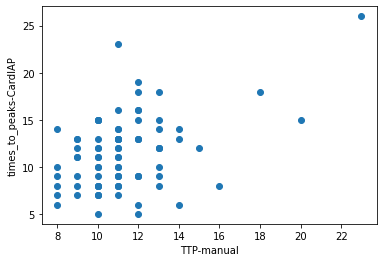

In [218]:
import matplotlib.pyplot as pp

# plot
pp.scatter(df_manual['TTP_deriv'],df_manual['TTP'])
pp.ylabel('times_to_peaks-CardIAP')
pp.xlabel('TTP-manual')

# pp.savefig('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/TTP_cadiap_1hz.png')

Text(0, 1, 'r-squared = -1.364')

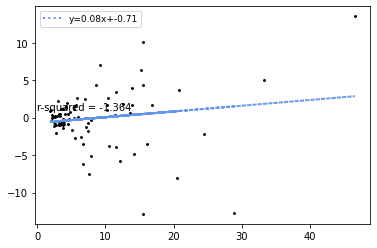

In [219]:
from scipy import stats
from sklearn.metrics import r2_score
#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(w,z)

line = slope*w+intercept
lines = plt.plot(w, line, 'cornflowerblue', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
#end
plt.setp(lines, color='cornflowerblue', linewidth=2.0,linestyle = ':')
plt.scatter(w,z, color="k", s=3.5)
plt.legend(fontsize=9)
plt.annotate("r-squared = {:.3f}".format(r2_score(w,z)), (0, 1))
# pp.savefig('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/TTP_cadiap_1hz.png')

In [ ]:
from statistics import variance

diff = x[:48]-y[:48]
print(diff.mean())
print(diff.std())
print(x[:48].mean(),x[:48].std(),variance(x[:48]),y[:48].mean(),y[:48].std(),variance(y[:48]))

In [ ]:
stats.ttest_1samp(diff, 0.0)

In [ ]:
scipy.stats.levene(x[:48],y[:48],center='trimmed', proportiontocut=0.05)

### Precisión y exactitud TTP

In [190]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
file_tabulado = pd.read_excel(path + 'tab_prueba3.xlsx')
del file_tabulado['Unnamed: 0']

In [191]:
file_tabulado = file_tabulado[(file_tabulado['frecuencia']==1) & (file_tabulado['tratamiento']=='c')]

In [192]:
experimentos = list(df_manual['experimento'].drop_duplicates())
filter_tabulado = pd.DataFrame()
for i in experimentos:
    filter_tabulado = filter_tabulado.append(file_tabulado[file_tabulado['experimento'] == i])

In [193]:
import operator

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
json_files = os.listdir(path + 'jsons/')
dict_min_dist = {1:200,3:70,4:50,5:35,6:20} 
TTPs = []
for file in json_files:
    try:
        # read json file
        dictres = jasonReader(path + 'jsons/' + file)
        #extract intensities values
        array = dictres['image']['intensities']
        #filter frequency for minimun distance
        experiment = file.split('_')[0][:6]
        photo = file.split('_')[-1].split('.')[0]
        freq = filter_tabulado[(filter_tabulado['experimento'].isin([experiment])) &  (filter_tabulado['foto'].isin([photo]))]['frecuencia'].reset_index(drop=True)[0]
        dist_between_peaks = dict_min_dist[freq]
        # Dobble Derivate values
        yhat1 = savitzky_golay(np.array(array), 25, 8 ,1)
#         yhat = yhat.astype(np.float32, copy=False)
#         yhat = cv2.bilateralFilter(yhat, 11, 150, 150)
#         yhat1 = derivate_date(yhat[:,0])
#         yhat1 = savitzky_golay(np.array(yhat), 25, 8 ,1)
        #Find minimum values for data
        min_peaks_positions = _min_peaks_positions(array, _max_peaks_positions(array, dist_between_peaks))
        min_peaks_positions_deriv = _max_peaks_positions(yhat1, dist_between_peaks)
        max_peaks_positions = _max_peaks_positions(array, dist_between_peaks)
        #TTP
        TTP = list(map(operator.sub, max_peaks_positions,min_peaks_positions))
        TTP_deriv = list(map(operator.sub, max_peaks_positions,min_peaks_positions_deriv))
        TTPs.append(TTP_deriv)
        print(experiment,photo,freq,TTP_deriv)
    except KeyError:
        pass

050320 8b000 1 [10, 13]
200121 c3a000 1 [12, 9]
010719 ctrol8b0 1 [18, 23]
171019 c1a000 1 [10, 10]
010819 c1a000 1 [20, 12]
050320 3a001 1 [13, 14]
120121 4a000 1 [11, 12]
070119 c7a000 1 [9, 9]
200121 c2a000 1 [12, 10]
200121 c1a000 1 [11, 14]
170719 c1a000 1 [8, 11]
050320 7a001 1 [12, 9]
010819 c3a000 1 [11, 12]
230819 otra1hz1 1 [11, 11]
030321 C4a000 1 [11, 10]
120121 5a000 1 [10, 13]
070119 c5a001 1 [12, 12]
120121 1a000 1 [10, 10]
070119 c3a001 1 [9, 9]
030321 C3a000 1 [13, 10]
240221 C1a000 1 [11, 11]
060121 c9a000 1 [14, 11]
230819 ctrol2a0 1 [9, 12]
071119 c1a002 1 [10, 10]
311019 c6a000 1 [11, 11]
060320 1a000 1 [8, 11]
060121 c8a000 1 [13, 10]
170719 c5a000 1 [11, 13]
060121 c3a000 1 [10, 11]
171019 c6a000 1 [12, 12]
240221 C2a000 1 [15, 13]
060121 c1a000 1 [11, 10]
030321 C1a000 1 [11, 11]
050320 5a001 1 [12, 11]
120121 2a000 1 [11, 11]
060320 1a000 1 [10, 11]
070119 c6a000 1 [8, 9]
120121 3a000 1 [11, 12]
220119 ctrol1a0 1 [12, 11]
030321 C2a000 1 [10, 10]
311019 c1a000 

In [194]:
out = []
for sublist in TTPs:
    out.extend(sublist)

In [195]:
print(min(out),max(out))

8 57


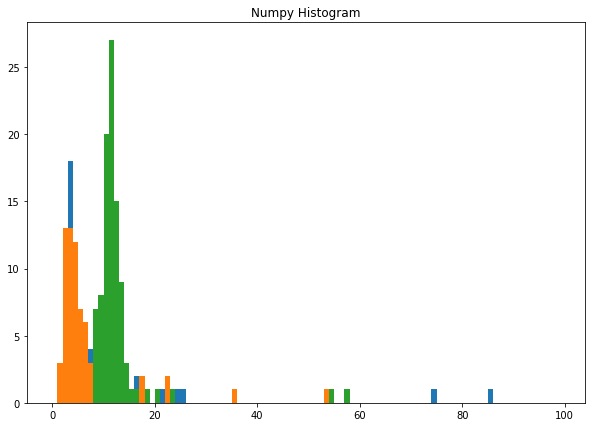

In [196]:
# Creating plot
fig = plt.figure(figsize =(10, 7))
 
plt.hist(y, bins = range(0,100))
plt.hist(x, bins = range(100))
plt.hist(out, bins = range(100))
plt.title("Numpy Histogram")
 
# show plot
plt.show()

## Análisis de AR

In [ ]:
path_ar = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/ARs/'

In [ ]:
path_tabulado = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/'
file_tabulado = pd.read_csv(path_tabulado + 'tabulado_imagenes.csv')
del file_tabulado['Unnamed: 0']

In [ ]:
experiments = os.listdir(path_ar)
dif_amp = []
dias = file_tabulado['experimento'].drop_duplicates()
foto = file_tabulado['foto'].drop_duplicates()
for j in dias:
    for k in foto:
        for i in range(0,len (experiments)):
            if (str(j) in experiments[i]) & (k in experiments[i]):
                file_tabulado['experimento']
                ar = pd.read_csv(path_ar + experiments[i],sep='\t',decimal=',')
                dif_amp.append([experiments[i],ar['local AR'].mean()])
                index = file_tabulado.index[(file_tabulado['experimento'] == j) & (file_tabulado['foto'] == k)].tolist()
                file_tabulado.loc[index,'AR'] = ar['local AR'].mean()

In [ ]:
file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['AR']<0.3) & (file_tabulado['frecuencia']==5)]

In [ ]:
file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==1)]['AR'].plot.hist(bins=20, alpha=0.5)
file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].plot.hist(bins=20, alpha=0.5)

In [ ]:
print(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==1)]['AR'].median())
print(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==1)]['AR'].std())
print(file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].median())
print(file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].std())

In [ ]:
from scipy import stats

stats.ks_2samp(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==5)]['AR'], file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'])

### DICRI

In [ ]:
tab = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/tabulado_imagenes.csv', encoding='utf-8')
del tab['Unnamed: 0']
pd.set_option('display.max_rows', None)
controles = tab[tab['tratamiento'] == 'c']
controles = controles.reset_index(drop=True)

In [ ]:
exps = os.listdir(path + 'jsons/')
experiments = []
for j in range(0,len(exps)):
    for i in range(0,len(controles)):
        if str(controles['experimento'][i]) in exps[j]:
            if str(controles['foto'][i]) in exps[j]:
                experiments.append(exps[j])

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
# experiments = os.listdir(path + 'jsons/')
complete_file = pd.DataFrame()
for i in range(0,len (experiments)):
    try:
        experiment = jasonReader(path + 'jsons/' + experiments[i])
        amp_files = slicesParser_amplitudes(experiment).filter(['transient1','transient2'])
        amp_files = amp_files[:][0:33]
        transient_max = []
        for j in range(1,len(amp_files)+1):
            transient_max.append(max(amp_files['transient1'][j],amp_files['transient2'][j]))
        amp_files['transient_max'] = transient_max
        amp_files.loc[len(amp_files)+1] = (amp_files.mean())
        amp_files.loc[len(amp_files)+1] = [amp_files['transient1'][len(amp_files)]*100/amp_files['transient_max'][len(amp_files)],amp_files['transient2'][len(amp_files)]*100/amp_files['transient_max'][len(amp_files)],'']
        amp_files[str(experiments[i])] = list(range(1,len(amp_files)-1))+['promedios']+['porcentaje_max']
        complete_file = pd.concat([complete_file,amp_files], axis=1)
    except ValueError:
        print(experiments[i])

In [ ]:
complete_file.to_excel(path + 'DICRI_controles.xlsx', engine='xlsxwriter')  

### Amplitud de transitorio global vs DI

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/'
file_tabulado = pd.read_csv(path + 'tabulado_parceado.csv')
file_tabulado.head() 

In [ ]:
experiment = jasonReader(path + 'jsons/050320c8_analysis_result_8b000.json')
allSlices = experiment['slices']
for i in range(0,len(allSlices)):
    print(allSlices[i]['amplitudes'])

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/whole_cell/'
experiments = os.listdir(path)
df = pd.DataFrame()
for experiment in experiments:
    df = pd.read_csv(path + experiment, sep = '\t', index_col=0).loc['amplitudes']
    for imagen in range(0,len(file_tabulado)):
        cel = file_tabulado['célula'].loc[imagen]
        foto = file_tabulado['foto'].loc[imagen]
        if (cel in experiment) & (foto in experiment):
            print(experiment,df)

#     print (experiment, df)